Как видно по схеме не предсказываются абсолютные значения смещений. Почему вместо того что бы в понятной регрессионной задаче не предсказать 4 числа предсказываются  коеффициенты, с которыми затем происходят неочевидные преобразования?

Что бы ответить на этот вопрос вспомним про нормализацию данных. Мы нормализуем входные данные, чаще всего так что бы среднее заначение было 0.

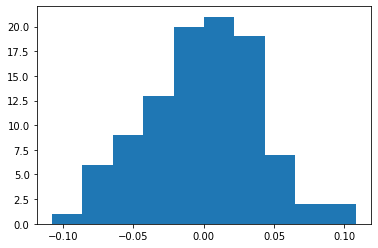

Mean: -0.00 Variance: 1.01


In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.randn((512,100)) # Fake normalized data
plt.hist(x.mean(dim=0),bins=10)
plt.show()
print(f"Mean: {x.mean().item():.2f} Variance: {x.var().item():.2f}")

 Кроме того мы определенным образом инициализируем веса и добавляем слои ализации что бы распределение входов очередного слоя (они же выходы предидущего) более-менее сохранялось.  

In [ ]:
from torch import nn
net = nn.Sequential(
    nn.Linear(100,50), # weights randomly sampled from some random distribution
    nn.ReLU(),
    #nn.BatchNorm1d(50),
    nn.Linear(50,1))

Веса инициализированны равномерно расперделены вокруг нуля:

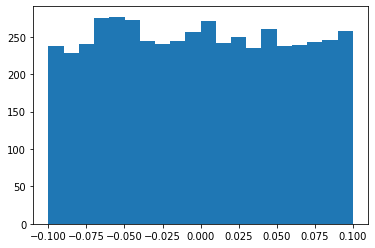

-0.000316677


In [ ]:
weights = net[0].weight.data.numpy()
plt.hist(weights.flatten(),bins=20)
plt.show()
print(weights.mean())

И на выходе последнего слоя будет та же ситуация: необученная сеть будет чаще всего предсказывать около нулевые значения:

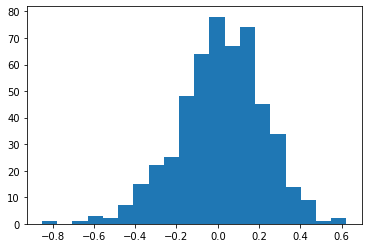

Mean: 0.02 Variance: 0.04


In [ ]:
out = net(x)
plt.hist(out.detach().numpy(),bins=20)
plt.show()
print(f"Mean: {out.mean().item():.2f} Variance: {out.var().item():.2f}")

Если мы будем пытаться предсказывать большие по модулю значения, например абсолютные координаты:

In [ ]:
targets = torch.randint(0,224,(512,1)) # fake coordinate in range [0 .. 255]
print(targets[:10].flatten())

То получим огромную ошибку, которая повлечет большое обновление весов приведет к нестабильному обучению, большим абсолютным значениям весов и.т.п.

In [ ]:
criterion = nn.MSELoss()
loss = criterion(out, targets)
print("Loss",loss.item())

Loss 17235.013671875


Если мы стандартизуем координаты(targets)

In [ ]:
mean = targets.float().mean()
std = targets.float().std()

transformed_targets = (targets - mean)/std
print(transformed_targets.flatten()[:10])

tensor([-0.2616, -1.4577, -1.2430, -1.1050, -0.6296,  1.6092,  0.3671,  1.5632,
        -0.8443,  1.3025])


То получим ошибку на 4 порядка меньше:

In [ ]:
loss = criterion(out, transformed_targets)
print("Loss", loss.item())

Loss 1.3939437866210938


Фактически теперь мы предсказываем смещение от среднего значения. Что бы его затем использовать надо его денормализовать

In [ ]:
real_out = out*std + mean
print(real_out.int().flatten()[:10]) # values like a coords

tensor([ 73,  91, 121, 139, 176, 142,  72,  63, 103, 153], dtype=torch.int32)


Иногда такую постобработку удобно включить в модель, что бы она учитывалась при подсчете loss. 

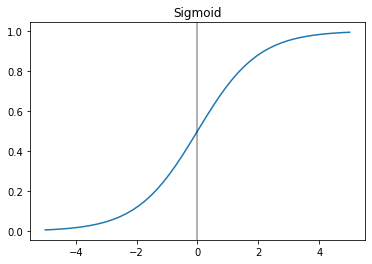

In [ ]:
import numpy as np
x = np.linspace(-5, 5)
y = 1/(1 + np.exp(-x))
plt.plot(x, y)
plt.axvline(0, color="black", alpha=0.4)
plt.title("Sigmoid")
plt.show()

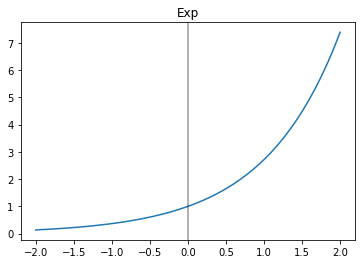

In [ ]:
import numpy as np
x = np.linspace(-2, 2)
y = np.exp(x)
plt.plot(x, y)
plt.axvline(0, color="black", alpha=0.4)
plt.title("Exp")
plt.show()